In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

import re
import json

import nltk
from nltk.stem import WordNetLemmatizer
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

from tqdm import tqdm

In [2]:
from transformers import pipeline

In [3]:
import spacy

# Load nlp model
nlp = spacy.load('en_core_web_sm')

# Load Data

In [4]:
df_main = pd.read_csv('sample-mcd.csv', encoding='latin1')

print(df_main.info())
df_main.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   reviewer_id   100 non-null    int64 
 1   review_time   100 non-null    object
 2   review        100 non-null    object
 3   rating        100 non-null    object
 4   review_clean  99 non-null     object
dtypes: int64(1), object(4)
memory usage: 4.0+ KB
None


,reviewer_id,review_time,review,rating,review_clean
0,1,3 months ago,Why does it look like someone spit on my food?...,1 star,look like someone spit food . normal transacti...
1,2,5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars,would mcdonalds . far food atmosphere go . sta...
2,3,5 days ago,Made a mobile order got to the speaker and che...,1 star,make mobile order get speaker check line not m...
3,4,a month ago,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,5 stars,mc . crispy chicken sandwich customer service ...
4,5,2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star,"repeat order 3 time drive thru , still manage ..."


In [5]:
with open("meta-data.json", "r") as file:
    data = json.load(file)

data

{'0': {'reviewer_id': 1,
  'review_time': '2024-09-06',
  'rating': 1,
  'review': 'Why does it look like someone spit on my food?\nI had a normal transaction,  everyone was chill and polite, but now i dont want to eat this. Im trying not to think about what this milky white/clear substance is all over my food, i d*** sure am not coming back.',
  'review_processed': "I had a normal transaction, everyone was calm and polite, but now I don't want to eat this. I'm trying not to think about what this milky white/clear substance is all over my food, and I'm sure I'm not coming back.",
  'aspect_sentiment': [{'term': 'food',
    'class': 'negative',
    'probability': [0.9815933108329773,
     0.015454968437552452,
     0.002951699076220393],
    'context': ["I had a normal transaction, everyone was calm and polite, but now I don't want to eat this.",
     "I'm trying not to think about what this milky white/clear substance is all over my food, and I'm sure I'm not coming back."]},
   {'term

In [6]:
df = pd.DataFrame.from_dict(data, orient='index')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   reviewer_id       100 non-null    int64 
 1   review_time       100 non-null    object
 2   rating            100 non-null    int64 
 3   review            100 non-null    object
 4   review_processed  100 non-null    object
 5   aspect_sentiment  100 non-null    object
dtypes: int64(2), object(4)
memory usage: 5.5+ KB
None


,reviewer_id,review_time,rating,review,review_processed,aspect_sentiment
0,1,2024-09-06,1,Why does it look like someone spit on my food?...,"I had a normal transaction, everyone was calm ...","[{'term': 'food', 'class': 'negative', 'probab..."
1,2,2024-12-01,4,It'd McDonalds. It is what it is as far as the...,"The staff at McDonald's are friendly, accommod...","[{'term': 'fast food', 'class': 'positive', 'p..."
2,3,2024-12-01,1,Made a mobile order got to the speaker and che...,I made a mobile order got to the speaker and c...,"[{'term': 'speaker', 'class': 'neutral', 'prob..."
3,4,2024-11-06,5,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,"Crispy chicken sandwich was delicious, and cus...","[{'term': 'sandwich', 'class': 'positive', 'pr..."
4,5,2024-10-06,1,"I repeat my order 3 times in the drive thru, a...",I repeat my order three times in the drive thr...,"[{'term': 'fries', 'class': 'negative', 'proba..."


# Aspect Classification

In [7]:
aspects = {}
text = ""
for items in df['aspect_sentiment'].values:
    for item in items:
        term = item.get('term')
        text = text + term + " " 
        if term not in aspects.keys():
            aspects[term] = 1
        else:
            aspects[term] = aspects[term] + 1
aspects

{'food': 24,
 'substance': 1,
 'fast food': 6,
 'atmosphere': 1,
 'staff': 13,
 'speaker': 2,
 'sandwich': 2,
 'service': 15,
 'customer': 1,
 'crispy chicken sandwich': 2,
 'fries': 9,
 'meal': 8,
 'filet of fish': 1,
 'wait': 5,
 'door': 1,
 'cookies': 1,
 'hamburg': 1,
 'customer service': 5,
 'cup': 1,
 'tea': 2,
 'sweet': 1,
 'coffee': 3,
 'chicken mcnuggets': 1,
 'manager': 8,
 'sauce': 3,
 'chicken': 2,
 'drinks': 2,
 'food items': 1,
 'night crew': 1,
 'morning crew': 1,
 'sausage': 1,
 'egg': 1,
 'syrup': 1,
 'butter': 1,
 'breakfast with hot cakes': 1,
 'utensils': 1,
 'condiments': 1,
 'food burger': 1,
 'drink cups': 1,
 'chicken sandwich': 1,
 'tables': 1,
 'cookie': 1,
 'apples strawberries': 1,
 'bag of food': 1,
 'drink': 4,
 'water': 1,
 'strawberry banana smoothies': 1,
 'smoothie': 1,
 'hash brownsies': 1,
 'appearance': 1,
 'bathrooms': 1,
 'lobby': 1,
 'order taker': 1,
 'morning staff': 1,
 'evening staff': 1,
 'caffeine': 1,
 'money': 1,
 'card': 1,
 'ice cream':

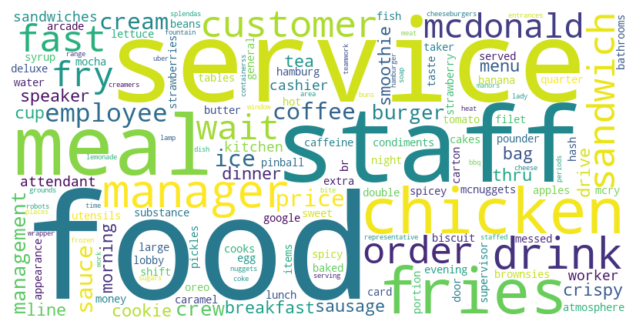

In [8]:
from wordcloud import WordCloud


# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Plot the word cloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [9]:
class_aspects = {
    "Food and Menu Items": [
      "food",
      "fast food",
      "fries",
      "meal",
      "sandwich",
      "burger",
      "chicken",
      "hamburg",
      "chicken mcnuggets",
      "filet of fish",
      "crispy chicken sandwich",
      "spicy chicken sandwich",
      "chicken sandwiches",
      "spicey chicken sandwiches",
      "cheeseburgers",
      "burgers",
      "pounder",
      "quarter",
      "double",
      "buns",
      "meat",
      "lettuce and tomato",
      "egg",
      "syrup",
      "breakfast with hot cakes",
      "sausage biscuit",
      "cookies",
      "cookie",
      "ice cream",
      "cream",
      "oreo mcry",
      "apples strawberries",
      "coffee",
      "drink",
      "drinks",
      "tea",
      "water",
      "strawberry banana smoothies",
      "smoothie",
      "caffeine",
      "fountain drinks",
      "coke",
      "frozen lemonade",
      "caramel mocha"
    ],
    "Condiments": [
        "butter",
        "sausage",
        "sauce",
        "bbq sauce",
        "pickles",
        "sugars",
        "creamers",
        "splendas"
    ],
    "Service and Staff": [
        "staff",
        "employees",
        "worker",
        "workers",
        "attendant",
        "attendants",
        "kitchen staff",
        "morning staff",
        "evening staff",
        "crew",
        "supervisor",
        "manager",
        "shift manager",
        "representative",
        "service",
        "customer service",
        "attitude",
        "teamwork",
        "manors",
        "management",
        "time management"
        "employee",
        "cashier",
        "general",
        "night crew",
        "morning crew",
        "lady",
    ],
    "Experience and Environment": [
        "wait",
        "order",
        "orders",
        "drive",
        "drive thru line",
        "thru line",
        "line",
        "door",
        "lobby",
        "appearance",
        "bathrooms",
        "food window",
        "heat lamp",
        "portion",
        "atmosphere",
        "places",
        "entrances",
        "taste",
        "work",
        "served",
        "meal periods",
        "uber",
        "substance",
    ],
    "Packaging": [
        "bag",
        "bag of food",
        "carton",
        "hamburger wrapper",
        "fry containerss",
    ],
    "Pricing and Value": [
        "price",
        "prices",
        "price range"
    ]
}
# Else: Miscellaneous

In [10]:
def get_key(dictionary, value):
    for k, v in dictionary.items():
        if value in v:
            return k
    return 'Miscellaneous'

def generate_topics(dictionary):
    return list(dictionary.keys()) + ['Miscellaneous']

# Table Main

In [11]:
df.head()

,reviewer_id,review_time,rating,review,review_processed,aspect_sentiment
0,1,2024-09-06,1,Why does it look like someone spit on my food?...,"I had a normal transaction, everyone was calm ...","[{'term': 'food', 'class': 'negative', 'probab..."
1,2,2024-12-01,4,It'd McDonalds. It is what it is as far as the...,"The staff at McDonald's are friendly, accommod...","[{'term': 'fast food', 'class': 'positive', 'p..."
2,3,2024-12-01,1,Made a mobile order got to the speaker and che...,I made a mobile order got to the speaker and c...,"[{'term': 'speaker', 'class': 'neutral', 'prob..."
3,4,2024-11-06,5,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,"Crispy chicken sandwich was delicious, and cus...","[{'term': 'sandwich', 'class': 'positive', 'pr..."
4,5,2024-10-06,1,"I repeat my order 3 times in the drive thru, a...",I repeat my order three times in the drive thr...,"[{'term': 'fries', 'class': 'negative', 'proba..."


In [12]:
topic_json = {k: 0 for k in list(class_aspects.keys()) + ["Miscellaneous"]}
topic_json

{'Food and Menu Items': 0,
 'Condiments': 0,
 'Service and Staff': 0,
 'Experience and Environment': 0,
 'Packaging': 0,
 'Pricing and Value': 0,
 'Miscellaneous': 0}

**Topic Classification**

In [13]:
# Topic records

records = []
for _, row in df.iterrows():
    record = {'reviewer_id': row['reviewer_id']}
    items = row['aspect_sentiment']
    record.update(topic_json.copy())
    for item in items:
        term = item['term']
        topic = get_key(class_aspects, term)
        record[topic] = 1
    records.append(record)

records

[{'reviewer_id': 1,
  'Food and Menu Items': 1,
  'Condiments': 0,
  'Service and Staff': 0,
  'Experience and Environment': 1,
  'Packaging': 0,
  'Pricing and Value': 0,
  'Miscellaneous': 0},
 {'reviewer_id': 2,
  'Food and Menu Items': 1,
  'Condiments': 0,
  'Service and Staff': 1,
  'Experience and Environment': 1,
  'Packaging': 0,
  'Pricing and Value': 0,
  'Miscellaneous': 0},
 {'reviewer_id': 3,
  'Food and Menu Items': 0,
  'Condiments': 0,
  'Service and Staff': 0,
  'Experience and Environment': 0,
  'Packaging': 0,
  'Pricing and Value': 0,
  'Miscellaneous': 1},
 {'reviewer_id': 4,
  'Food and Menu Items': 1,
  'Condiments': 0,
  'Service and Staff': 1,
  'Experience and Environment': 0,
  'Packaging': 0,
  'Pricing and Value': 0,
  'Miscellaneous': 1},
 {'reviewer_id': 5,
  'Food and Menu Items': 1,
  'Condiments': 0,
  'Service and Staff': 0,
  'Experience and Environment': 0,
  'Packaging': 0,
  'Pricing and Value': 0,
  'Miscellaneous': 0},
 {'reviewer_id': 6,
  'Fo

**Save Table per Topic**

In [14]:
topic_df = pd.DataFrame.from_dict(records)

topic_df.head()

,reviewer_id,Food and Menu Items,Condiments,Service and Staff,Experience and Environment,Packaging,Pricing and Value,Miscellaneous
0,1,1,0,0,1,0,0,0
1,2,1,0,1,1,0,0,0
2,3,0,0,0,0,0,0,1
3,4,1,0,1,0,0,0,1
4,5,1,0,0,0,0,0,0


In [15]:
def formatting_aspect(items):
    format = ""
    for i, item in enumerate(items):
        term = item.get('term')
        sentiment = item.get('class')
        format += f"● {term}: {sentiment}"
        if i != len(items) - 1:
            format += "\n"
    return format

def generate_table(df: pd.DataFrame, topic_df: pd.DataFrame, topic: str):
    drop = ['review_processed']
    mask = topic_df[topic_df[topic] == 1]['reviewer_id'].values
    result = df[df['reviewer_id'].isin(mask)].copy()
    result['aspect_sentiment'] = result['aspect_sentiment'].apply(formatting_aspect)
    result['topic'] = [topic] * result.shape[0]
    result = result.drop(drop, axis=1).sort_values(by='review_time').reset_index(drop=True)

    return result

In [16]:
topics = generate_topics(class_aspects)

frames = []
for topic in topics:
    temp = generate_table(df, topic_df, topic)
    frames.append(temp)
    # Save to excel
    # temp.to_excel(f"table/main_mcd_{topic}.xlsx", index=False)

In [17]:
df_main = pd.concat(frames)

df_main.head()

,reviewer_id,review_time,rating,review,aspect_sentiment,topic
0,84,2019-12-06,3,Decent McDonald's location. The team here has...,● heat lamp: positive\n● food: positive\n● mea...,Food and Menu Items
1,94,2020-12-06,3,This place is okay. It has these kiosks where ...,● frozen lemonade: negative,Food and Menu Items
2,30,2021-12-06,1,First and last time I go to this location. Loo...,● pounder: positive\n● quarter: positive\n● do...,Food and Menu Items
3,81,2021-12-06,4,"I would have given 5 stars, the evening manage...",● sandwich: positive\n● crew: positive\n● mana...,Food and Menu Items
4,89,2021-12-06,1,This McDonalds CONSTANTLY gets orders wrong. W...,● manager: negative\n● fries: positive,Food and Menu Items


# Table Aspects

In [18]:
df.head()

,reviewer_id,review_time,rating,review,review_processed,aspect_sentiment
0,1,2024-09-06,1,Why does it look like someone spit on my food?...,"I had a normal transaction, everyone was calm ...","[{'term': 'food', 'class': 'negative', 'probab..."
1,2,2024-12-01,4,It'd McDonalds. It is what it is as far as the...,"The staff at McDonald's are friendly, accommod...","[{'term': 'fast food', 'class': 'positive', 'p..."
2,3,2024-12-01,1,Made a mobile order got to the speaker and che...,I made a mobile order got to the speaker and c...,"[{'term': 'speaker', 'class': 'neutral', 'prob..."
3,4,2024-11-06,5,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,"Crispy chicken sandwich was delicious, and cus...","[{'term': 'sandwich', 'class': 'positive', 'pr..."
4,5,2024-10-06,1,"I repeat my order 3 times in the drive thru, a...",I repeat my order three times in the drive thr...,"[{'term': 'fries', 'class': 'negative', 'proba..."


In [19]:
# Output: id, date, aspect, sentiment, topic
def recording_aspect(row):
    records = []
    id_ = row['reviewer_id']
    date_ = row['review_time']
    items = row['aspect_sentiment']
    rating = row['rating']
    
    for item in items:
        aspect = item.get('term')
        aspect = nlp(aspect)[0:].lemma_
        sentiment = item.get('class')
        topic = get_key(class_aspects, aspect)
        records.append({'reviewer_id': id_, 'review_time': date_, 'aspect':aspect, 'sentiment': sentiment, 'topic': topic, 'rating': rating})
    return records

In [20]:
records = []

for _, row in df.iterrows():
    records += recording_aspect(row)

records

[{'reviewer_id': 1,
  'review_time': '2024-09-06',
  'aspect': 'food',
  'sentiment': 'negative',
  'topic': 'Food and Menu Items',
  'rating': 1},
 {'reviewer_id': 1,
  'review_time': '2024-09-06',
  'aspect': 'substance',
  'sentiment': 'negative',
  'topic': 'Experience and Environment',
  'rating': 1},
 {'reviewer_id': 2,
  'review_time': '2024-12-01',
  'aspect': 'fast food',
  'sentiment': 'positive',
  'topic': 'Food and Menu Items',
  'rating': 4},
 {'reviewer_id': 2,
  'review_time': '2024-12-01',
  'aspect': 'atmosphere',
  'sentiment': 'positive',
  'topic': 'Experience and Environment',
  'rating': 4},
 {'reviewer_id': 2,
  'review_time': '2024-12-01',
  'aspect': 'food',
  'sentiment': 'positive',
  'topic': 'Food and Menu Items',
  'rating': 4},
 {'reviewer_id': 2,
  'review_time': '2024-12-01',
  'aspect': 'staff',
  'sentiment': 'positive',
  'topic': 'Service and Staff',
  'rating': 4},
 {'reviewer_id': 3,
  'review_time': '2024-12-01',
  'aspect': 'speaker',
  'sentim

In [21]:
df_record = pd.DataFrame.from_dict(records)

# Create pivot table
df_aspect = (
    df_record.groupby(["topic", "review_time", "aspect", "sentiment"])['review_time']
    .count()
    .unstack("sentiment", fill_value=0)
    .sort_values(by='review_time')
).reset_index()

df_aspect['total'] = df_aspect['negative'] + df_aspect['positive'] + df_aspect['neutral']
df_aspect = df_aspect.rename_axis(index=None, columns=None)

df_aspect

,topic,review_time,aspect,negative,neutral,positive,total
0,Miscellaneous,2019-12-06,kitchen,1,0,0,1
1,Miscellaneous,2019-12-06,serve,1,0,0,1
2,Miscellaneous,2019-12-06,meal period,1,0,0,1
3,Service and Staff,2019-12-06,service,1,0,0,1
4,Experience and Environment,2019-12-06,heat lamp,0,0,1,1
...,...,...,...,...,...,...,...
205,Experience and Environment,2024-12-01,atmosphere,0,0,1,1
206,Food and Menu Items,2024-12-01,fast food,0,0,1,1
207,Service and Staff,2024-12-01,staff,0,0,1,1
208,Experience and Environment,2024-12-03,wait,1,0,0,1


**Save Table per Aspect**

In [22]:
# df_aspect.to_excel("table/aspect-mcd.xlsx", index=False)

# Table Trend

In [23]:
df_record.head()

,reviewer_id,review_time,aspect,sentiment,topic,rating
0,1,2024-09-06,food,negative,Food and Menu Items,1
1,1,2024-09-06,substance,negative,Experience and Environment,1
2,2,2024-12-01,fast food,positive,Food and Menu Items,4
3,2,2024-12-01,atmosphere,positive,Experience and Environment,4
4,2,2024-12-01,food,positive,Food and Menu Items,4


In [24]:
# Create trend dataframe

temp_1 = ( df_record.groupby(["topic", "review_time"])
    .agg({'rating': ['sum', 'count']})
    .sort_values(by='review_time')
).reset_index()

temp_1.columns = ['_'.join(col).strip() if len(col[-1]) > 0 else col[0] for col in temp_1.columns.values]

temp_2 = (
    df_record.groupby(["topic", "review_time", "sentiment"])['review_time']
    .count()
    .unstack("sentiment", fill_value=0)
    .sort_values(by='review_time')
).reset_index()

df_trend = temp_1.merge(temp_2, on=['topic', 'review_time'])
df_trend['total'] = df_trend['negative'] + df_trend['positive'] + df_trend['neutral']

df_trend.head()

,topic,review_time,rating_sum,rating_count,negative,neutral,positive,total
0,Miscellaneous,2019-12-06,5,3,3,0,0,3
1,Experience and Environment,2019-12-06,4,2,1,0,1,2
2,Food and Menu Items,2019-12-06,3,1,0,0,1,1
3,Service and Staff,2019-12-06,1,1,1,0,0,1
4,Food and Menu Items,2020-12-06,3,1,1,0,0,1


In [25]:
# Fix datetime
# Convert review_time to datetime
df_trend['review_time'] = pd.to_datetime(df_trend['review_time'])

# Extract year and month
df_trend['month'] = df_trend['review_time'].apply(lambda x: x.replace(day=1).date())
df_trend['year'] = df_trend['review_time'].apply(lambda x: x.replace(day=1, month=1).date())
df_trend['review_time'] = df_trend['review_time'].apply(lambda x: x.date())

# Identify categorical and date columns
categorical_date_columns = ['topic', 'review_time', 'year', 'month']

# Identify numeric columns
numeric_columns = [col for col in df_trend.columns if col not in categorical_date_columns]


df_trend = df_trend[categorical_date_columns + numeric_columns]

df_trend.head()

,topic,review_time,year,month,rating_sum,rating_count,negative,neutral,positive,total
0,Miscellaneous,2019-12-06,2019-01-01,2019-12-01,5,3,3,0,0,3
1,Experience and Environment,2019-12-06,2019-01-01,2019-12-01,4,2,1,0,1,2
2,Food and Menu Items,2019-12-06,2019-01-01,2019-12-01,3,1,0,0,1,1
3,Service and Staff,2019-12-06,2019-01-01,2019-12-01,1,1,1,0,0,1
4,Food and Menu Items,2020-12-06,2020-01-01,2020-12-01,3,1,1,0,0,1


**Save Table Trend**

In [26]:
# df_trend.to_excel("table/trend.xlsx", index=False)

# Prepare Table for SWOT Analysis

In [27]:
swot_json = {k: "" for k in list(class_aspects.keys()) + ["Miscellaneous"]}
swot_json

{'Food and Menu Items': '',
 'Condiments': '',
 'Service and Staff': '',
 'Experience and Environment': '',
 'Packaging': '',
 'Pricing and Value': '',
 'Miscellaneous': ''}

In [28]:
for items in df['aspect_sentiment'].values:
    for item in items:
        if len(item) == 0:
            continue
        term = item.get('term')
        context = item.get('context')
        if len(context) > 0:
            context = context[0]
            class_ = get_key(class_aspects, term)
            if context not in swot_json[class_]:
                swot_json[class_] = swot_json[class_] + "- " + context + "\n"

df_context_topic = pd.DataFrame.from_dict(swot_json, 'index', columns=['context']).T
df_context_topic

,Food and Menu Items,Condiments,Service and Staff,Experience and Environment,Packaging,Pricing and Value,Miscellaneous
context,"- I had a normal transaction, everyone was cal...",- My 10 pieces of chicken were missing.\n- I w...,"- The staff at McDonald's are friendly, accomm...","- I had a normal transaction, everyone was cal...","- The boy who attended me made me wait, and wh...",- They did not honor there advertised price.\n...,- I made a mobile order got to the speaker and...


In [29]:
# df_context_topic.to_excel("table/context_table.xlsx", index=False)

PROMPT SUMMARIZE FORMAT:

Descriptive sentiment summary with bullet point format only about "topic": <text>

# Exploratory Data Analysis

**Table Trend**

In [62]:
# Distribution review

df_trend.head()

,topic,review_time,year,month,rating_sum,rating_count,negative,neutral,positive,total
0,Miscellaneous,2019-12-06,2019-01-01,2019-12-01,5,3,3,0,0,3
1,Experience and Environment,2019-12-06,2019-01-01,2019-12-01,4,2,1,0,1,2
2,Food and Menu Items,2019-12-06,2019-01-01,2019-12-01,3,1,0,0,1,1
3,Service and Staff,2019-12-06,2019-01-01,2019-12-01,1,1,1,0,0,1
4,Food and Menu Items,2020-12-06,2020-01-01,2020-12-01,3,1,1,0,0,1


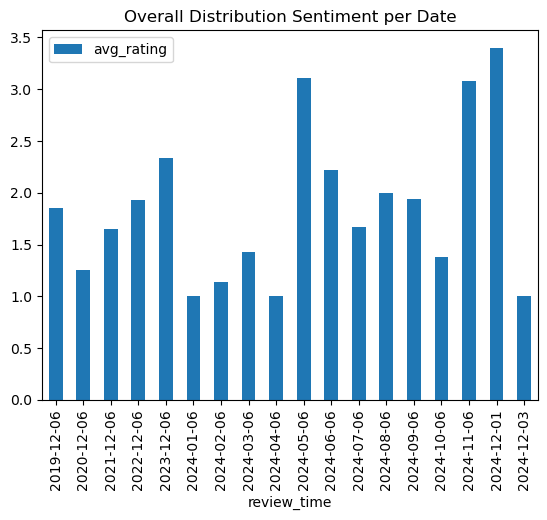

In [109]:
temp = df_trend.groupby('review_time').agg({'rating_sum': 'sum', 'rating_count': 'sum'})
temp['avg_rating'] = (temp['rating_sum'] / temp['rating_count']).fillna(0)

temp.drop(['rating_sum', 'rating_count'], axis=1).plot(kind='bar', title="Overall Distribution Average Rating per Date")
plt.show()

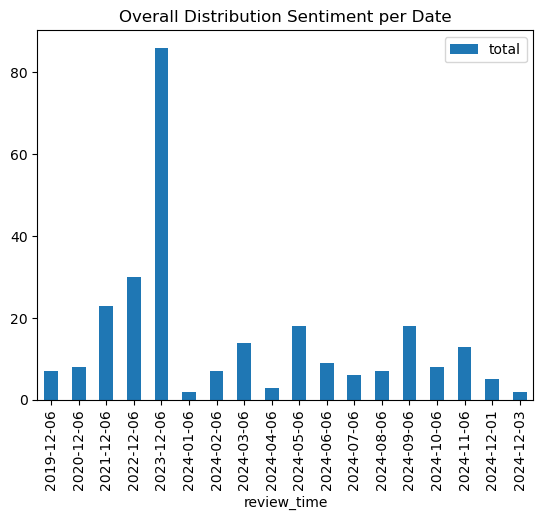

In [67]:
df_trend.groupby('review_time').agg({'total':'sum'}).plot(kind='bar', title="Overall Distribution Sentiment per Date")
plt.show()

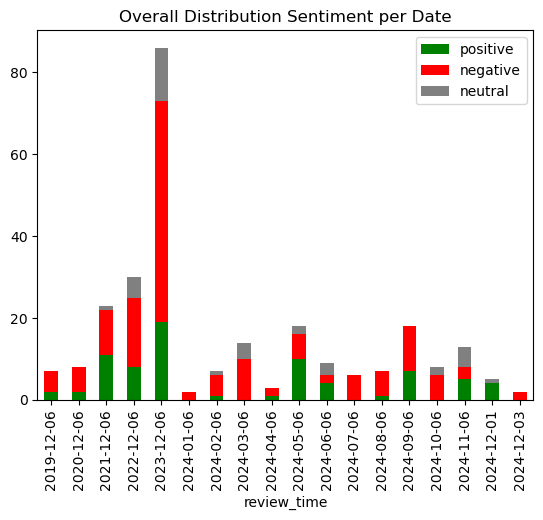

In [72]:
df_trend\
    .groupby('review_time')\
    .agg({'positive':'sum', 
          'negative':'sum',
          'neutral': 'sum'})\
    .plot(kind='bar', 
          title="Overall Distribution Sentiment per Date",
          stacked=True, 
          color=['green', 'red', 'gray'])

plt.show()

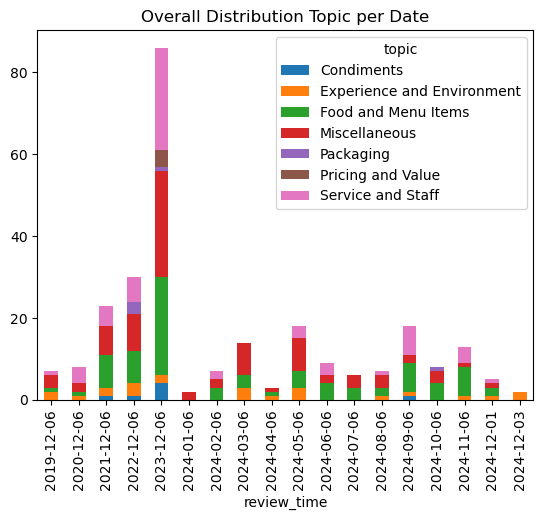

In [86]:
df_trend\
    .groupby(['review_time', 'topic'])\
    .agg({'total': 'sum'})\
    .rename({'total': 'count'}, axis=1)\
    .reset_index()\
    .pivot(index='review_time', columns='topic', values='count')\
    .fillna(0)\
    .plot(kind='bar', stacked=True, title='Overall Distribution Topic per Date')

plt.show()

**Table Aspect**

In [107]:
topics = generate_topics(class_aspects)

print(topics)

['Food and Menu Items', 'Condiments', 'Service and Staff', 'Experience and Environment', 'Packaging', 'Pricing and Value', 'Miscellaneous']


In [113]:
# VARIABLES
FROM_DATE = "2019-12-01"
TO_DATE = "2024-01-01"
TOPIC = "Food and Menu Items"

MIN_DATE = np.min(df_trend['review_time'])
FROM_DATE = pd.to_datetime(MIN_DATE).date() if len(FROM_DATE) == 0 else pd.to_datetime(FROM_DATE).date()


MAX_DATE = np.max(df_trend['review_time'])
TO_DATE = pd.to_datetime(MIN_DATE).date() if len(TO_DATE) == 0 else pd.to_datetime(TO_DATE).date()

In [114]:
df_aspect['review_time'] = df_aspect['review_time'].apply(lambda x: pd.to_datetime(x).date())
df_aspect.head()

,topic,review_time,aspect,negative,neutral,positive,total
0,Miscellaneous,2019-12-06,kitchen,1,0,0,1
1,Miscellaneous,2019-12-06,serve,1,0,0,1
2,Miscellaneous,2019-12-06,meal period,1,0,0,1
3,Service and Staff,2019-12-06,service,1,0,0,1
4,Experience and Environment,2019-12-06,heat lamp,0,0,1,1


FROM_DATE:  2019-12-01
TO_DATE:  2024-01-01


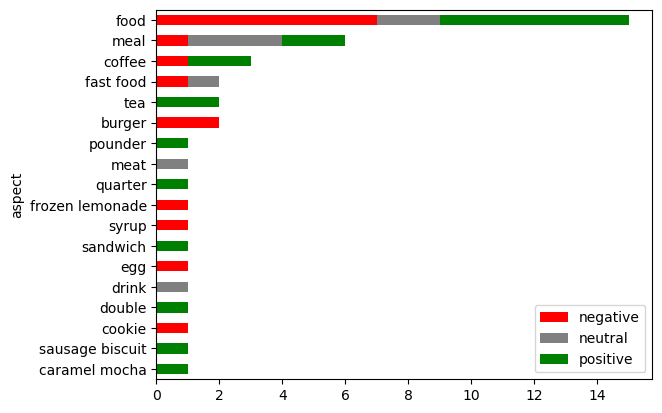

In [115]:
# Distribution per aspect

mask = (df_aspect['review_time'] >= FROM_DATE) & (df_aspect['review_time'] <= TO_DATE)
print("FROM_DATE: ", FROM_DATE)
print("TO_DATE: ", TO_DATE)

temp = df_aspect[mask].copy()
if TOPIC:
    mask = (temp['topic'] == TOPIC)
    temp = temp[mask].copy()
    
temp = temp.drop(['review_time', 'topic'], axis=1).groupby(['aspect']).sum().sort_values(by='total', ascending=True)

temp\
    .drop(['total'], axis=1)\
    .plot(kind='barh',
          stacked=True,
          color=['red', 'gray', 'green'])

plt.show()

**Table Main**

In [116]:
df_main['review_time'] = df_main['review_time'].apply(lambda x: pd.to_datetime(x).date())
df_main.head()

,reviewer_id,review_time,rating,review,aspect_sentiment,topic
0,84,2019-12-06,3,Decent McDonald's location. The team here has...,● heat lamp: positive\n● food: positive\n● mea...,Food and Menu Items
1,94,2020-12-06,3,This place is okay. It has these kiosks where ...,● frozen lemonade: negative,Food and Menu Items
2,30,2021-12-06,1,First and last time I go to this location. Loo...,● pounder: positive\n● quarter: positive\n● do...,Food and Menu Items
3,81,2021-12-06,4,"I would have given 5 stars, the evening manage...",● sandwich: positive\n● crew: positive\n● mana...,Food and Menu Items
4,89,2021-12-06,1,This McDonalds CONSTANTLY gets orders wrong. W...,● manager: negative\n● fries: positive,Food and Menu Items


In [119]:
mask = (df_main['review_time'] >= FROM_DATE) & (df_main['review_time'] <= TO_DATE)
print("FROM_DATE: ", FROM_DATE)
print("TO_DATE: ", TO_DATE)

temp = df_main[mask].copy()
if TOPIC:
    mask = (temp['topic'] == TOPIC)
    temp = temp[mask].copy()

temp = temp[['review', 'aspect_sentiment', 'rating']].sort_values(by='rating', ascending=False)
temp

FROM_DATE:  2019-12-01
TO_DATE:  2024-01-01


,review,aspect_sentiment,rating
32,Hashbrowns were fire today.\n\nFrappes always ...,● coffee: positive\n● workers: positive,5
29,The cashier's are very nice. Its very clean on...,● service: positive\n● food: positive\n● cashi...,5
21,I go here all the time. Great staff.. NVR get ...,● customer service: negative\n● food: negative...,4
12,The staff is very kind and the food is usually...,● places: positive\n● entrances: negative\n● d...,4
3,"I would have given 5 stars, the evening manage...",● sandwich: positive\n● crew: positive\n● mana...,4
30,The line wS extremely big and was moving very ...,● staff: negative\n● cookie: negative\n● apple...,4
28,"Service is slow, but I get all of my items wit...",● meal: positive\n● service: negative\n● bite:...,4
19,Me and my girlfriend came tonight to pick up o...,● mcdonald: positive\n● food: positive,3
24,They got our order correct and didn't cut me o...,● speaker: positive\n● food: neutral\n● fast f...,3
1,This place is okay. It has these kiosks where ...,● frozen lemonade: negative,3
